In [1]:
!pip install imbalanced-learn streamlit plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 67.3 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [4]:
import pandas as pd
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Copy to avoid warnings
df_clean = df.copy()

# Convert TotalCharges to numeric (some values are blank strings)
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median())

# Drop customerID (not useful)
df_clean = df_clean.drop(columns=['customerID'])

# Encode target
y = (df_clean['Churn'] == "Yes").astype(int)
X = df_clean.drop(columns=['Churn'])

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data ready! Shape:", X_scaled.shape, "Target distribution:\n", y.value_counts())


Data ready! Shape: (7043, 30) Target distribution:
 Churn
0    5174
1    1869
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0     0.8308    0.8966    0.8625      1035
           1     0.6336    0.4947    0.5556       374

    accuracy                         0.7899      1409
   macro avg     0.7322    0.6956    0.7090      1409
weighted avg     0.7784    0.7899    0.7810      1409

ROC AUC: 0.8260766230075693
Confusion Matrix:
 [[928 107]
 [189 185]]


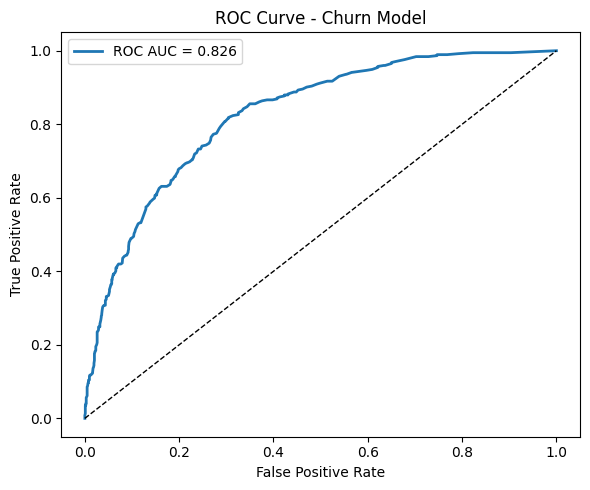

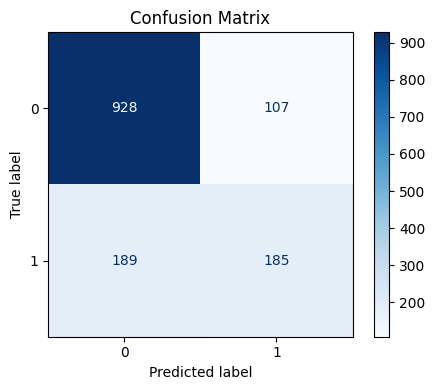

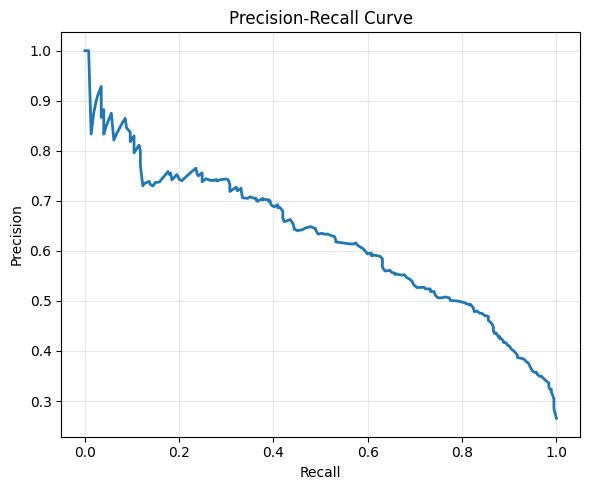

Saved: roc_curve.png, confusion_matrix.png, pr_curve.png


In [7]:
# Cell 1 — ROC, Confusion Matrix, Precision-Recall, save PNGs
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# assumes y_test, y_pred, y_prob exist from your baseline RF
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Model'); plt.legend()
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(values_format='d', ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pr_curve.png', dpi=150)
plt.show()

print("Saved: roc_curve.png, confusion_matrix.png, pr_curve.png")


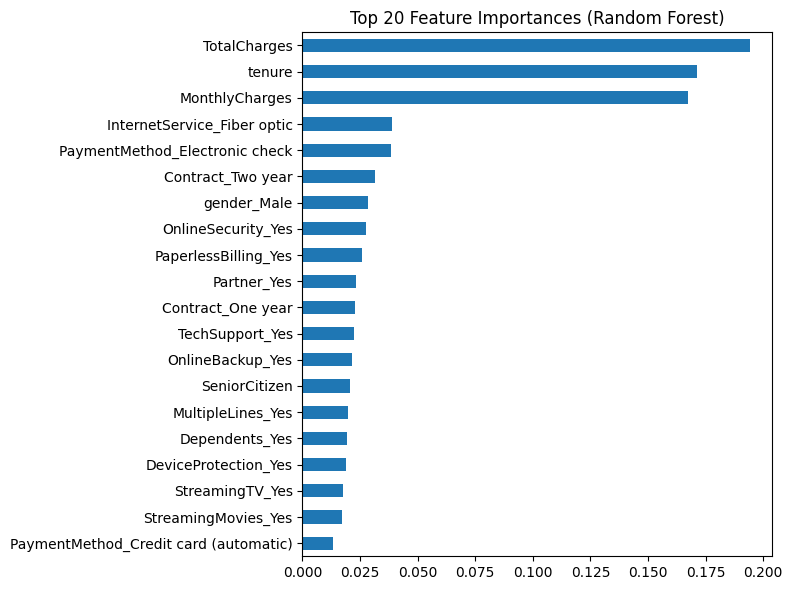

Top 10 features:
 ['TotalCharges', 'tenure', 'MonthlyCharges', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'Contract_Two year', 'gender_Male', 'OnlineSecurity_Yes', 'PaperlessBilling_Yes', 'Partner_Yes']


In [8]:
# Cell 2 — Top 20 feature importances
import pandas as pd
import matplotlib.pyplot as plt
try:
    feature_names = X.columns
except Exception:
    # if X is numpy, you may have a list 'cols' from preprocessing; adjust accordingly
    feature_names = cols if 'cols' in globals() else [f"f{i}" for i in range(X.shape[1])]

importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
fi.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

print("Top 10 features:\n", fi.index[:10].tolist())


In [9]:
# Cell 3 — class_weight='balanced' RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_w = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf_w.fit(X_train, y_train)
y_pred_w = rf_w.predict(X_test)
y_prob_w = rf_w.predict_proba(X_test)[:,1]

print("Classification Report (class_weight):\n", classification_report(y_test, y_pred_w, digits=4))
print("ROC AUC (class_weight):", roc_auc_score(y_test, y_prob_w))


Classification Report (class_weight):
               precision    recall  f1-score   support

           0     0.8311    0.8937    0.8613      1035
           1     0.6284    0.4973    0.5552       374

    accuracy                         0.7885      1409
   macro avg     0.7297    0.6955    0.7082      1409
weighted avg     0.7773    0.7885    0.7800      1409

ROC AUC (class_weight): 0.8244516779043634


In [10]:
# Cell 4 — SMOTE on training set then RF
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)   # only resample training set
print("Resampled train class counts:", pd.Series(y_res).value_counts())

rf_sm = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_sm.fit(X_res, y_res)
y_pred_sm = rf_sm.predict(X_test)
y_prob_sm = rf_sm.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print("Classification Report (SMOTE+RF):\n", classification_report(y_test, y_pred_sm, digits=4))
print("ROC AUC (SMOTE+RF):", roc_auc_score(y_test, y_prob_sm))


Resampled train class counts: Churn
0    4139
1    4139
Name: count, dtype: int64
Classification Report (SMOTE+RF):
               precision    recall  f1-score   support

           0     0.8525    0.8377    0.8450      1035
           1     0.5714    0.5989    0.5849       374

    accuracy                         0.7743      1409
   macro avg     0.7120    0.7183    0.7149      1409
weighted avg     0.7779    0.7743    0.7760      1409

ROC AUC (SMOTE+RF): 0.8252576920096101


In [11]:
# Cell 5 — XGBoost
import xgboost as xgb
xclf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xclf.fit(X_train, y_train)
y_prob_x = xclf.predict_proba(X_test)[:,1]
y_pred_x = xclf.predict(X_test)

from sklearn.metrics import classification_report, roc_auc_score
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_x, digits=4))
print("ROC AUC (XGBoost):", roc_auc_score(y_test, y_prob_x))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [21:31:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (XGBoost):
               precision    recall  f1-score   support

           0     0.8389    0.8754    0.8567      1035
           1     0.6079    0.5348    0.5690       374

    accuracy                         0.7850      1409
   macro avg     0.7234    0.7051    0.7129      1409
weighted avg     0.7776    0.7850    0.7804      1409

ROC AUC (XGBoost): 0.8214136247384329


In [12]:
# Cell 6 — threshold tuning for best F1 (on chosen probs — change 'probs' if using other model)
import numpy as np
from sklearn.metrics import f1_score

# Choose the probability array to tune: pick the model you prefer
probs = y_prob_sm if 'y_prob_sm' in globals() else (y_prob_w if 'y_prob_w' in globals() else y_prob)

best_thr, best_f1 = 0.5, 0
for thr in np.linspace(0.1,0.9,81):
    f1 = f1_score(y_test, (probs>thr).astype(int))
    if f1 > best_f1:
        best_f1 = f1; best_thr = thr

print("Best threshold by F1:", best_thr, "Best F1:", best_f1)

# Show confusion matrix at best threshold
from sklearn.metrics import confusion_matrix
y_hat_thr = (probs > best_thr).astype(int)
print("Confusion matrix at best threshold:\n", confusion_matrix(y_test, y_hat_thr))


Best threshold by F1: 0.29000000000000004 Best F1: 0.6163141993957704
Confusion matrix at best threshold:
 [[722 313]
 [ 68 306]]


In [13]:
# Cell 7 — save final model & scaler
import joblib
import os
os.makedirs("models", exist_ok=True)

# change model_name variable to the model you choose, e.g. 'rf_sm'
model_to_save = rf_sm if 'rf_sm' in globals() else (rf_w if 'rf_w' in globals() else (xclf if 'xclf' in globals() else rf))

joblib.dump(model_to_save, "models/churn_model_final.joblib")
joblib.dump(scaler, "models/scaler_churn.joblib")
print("Saved model -> models/churn_model_final.joblib and scaler -> models/scaler_churn.joblib")


Saved model -> models/churn_model_final.joblib and scaler -> models/scaler_churn.joblib
